In [337]:
%matplotlib inline
%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap
from getSkillPAGES import getSkill
from t_subsample import t_subsample

figdir = 'Figs/'

proxy_pandas_metafile = 'Pages2k_Metadata.df.pckl'
proxy_pandas_datafile = 'Pages2k_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)

# necessary to index this as I'd like. not sure why...
proxy_data.index=proxy_data.index.astype('float64')
proxy_data = proxy_data.astype('float64')

proxy_data = proxy_data[0:2011]

# Reformat the proxy_meta to get rid of special characters
proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

# Change the metadata file so that indices are NCDC IDs (better matchup with data file)
proxy_meta.index = proxy_meta['PAGES_ID']
proxy_meta=proxy_meta.rename(columns = {'PAGES_ID':'NCDC_ID'})

# Replace all proxy types with a placeholder for now

proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

# sort the metadata to have the same order as the data file
proxy_data = proxy_data.loc[:,proxy_meta.index]

# Remove one record that has a range of lat-lon values
proxy_data = proxy_data.drop('Eur_11',1)
proxy_meta = proxy_meta.drop('Eur_11',0)

proxy_data = proxy_data.dropna(1,'all')
#proxy_data = proxy_data.loc[proxy_meta.index]
proxy_meta = proxy_meta.loc[proxy_data.columns]

proxy_meta.loc[:,'Lat_N'] = proxy_meta.loc[:,'Lat_N'].astype('float64')
proxy_meta.loc[:,'Lon_E'] = proxy_meta.loc[:,'Lon_E'].astype('float64')


 Groups are coded as follows:
 - 'u':    nan,
 - 'c':   'Coral',
 - 'd':   'Documentary',
 - 'h':   'Historic',
 - 'ice': 'Ice_core',
 - 'i':   'Instrumental',
 - 'l':   'Lake_sediment',
 - 'm':   'Marine_sediment',
 - 's':   'Speleothem',
 - 't':   'Tree_ring'}



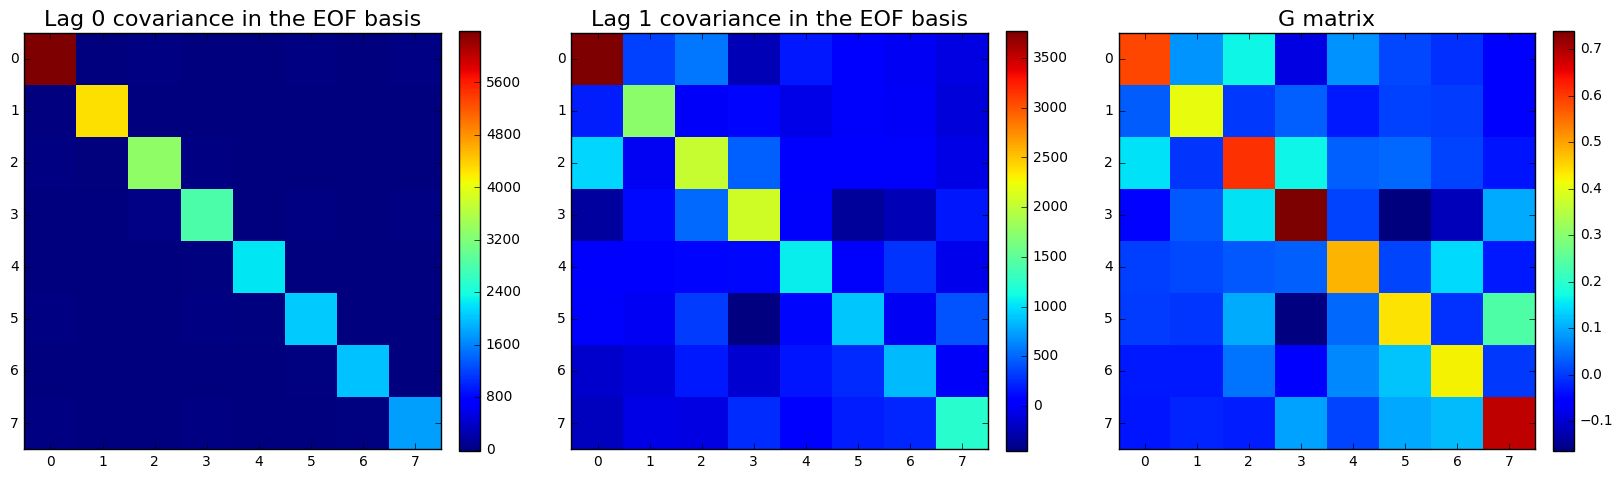

> /Users/dan/Dropbox (MIT)/2016-2017/LMR/getSkillPAGES.py(256)getSkill()
-> groups = pm.groupby('Archive_type')
(Pdb) c


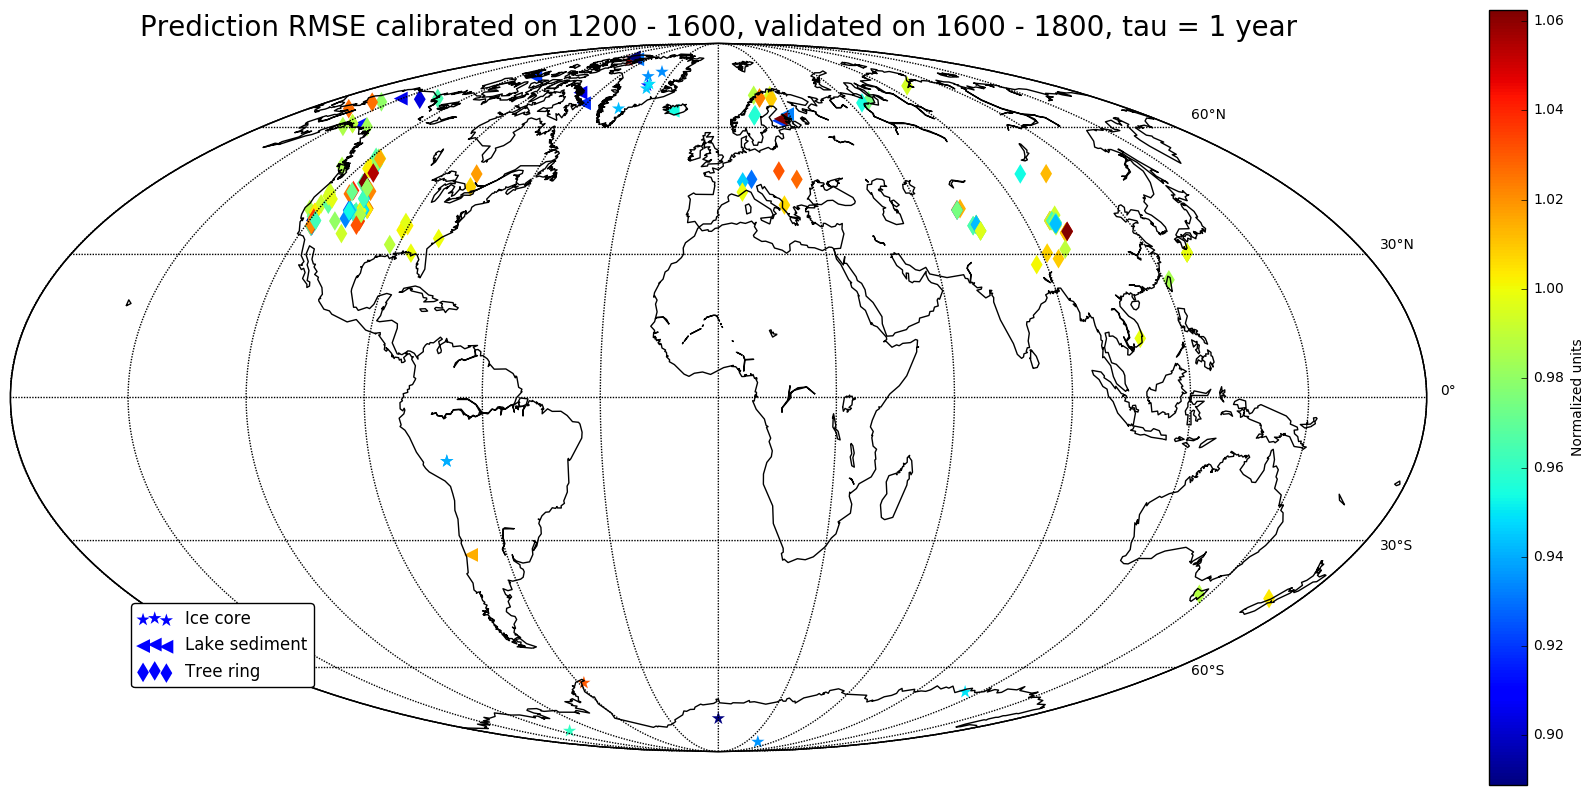

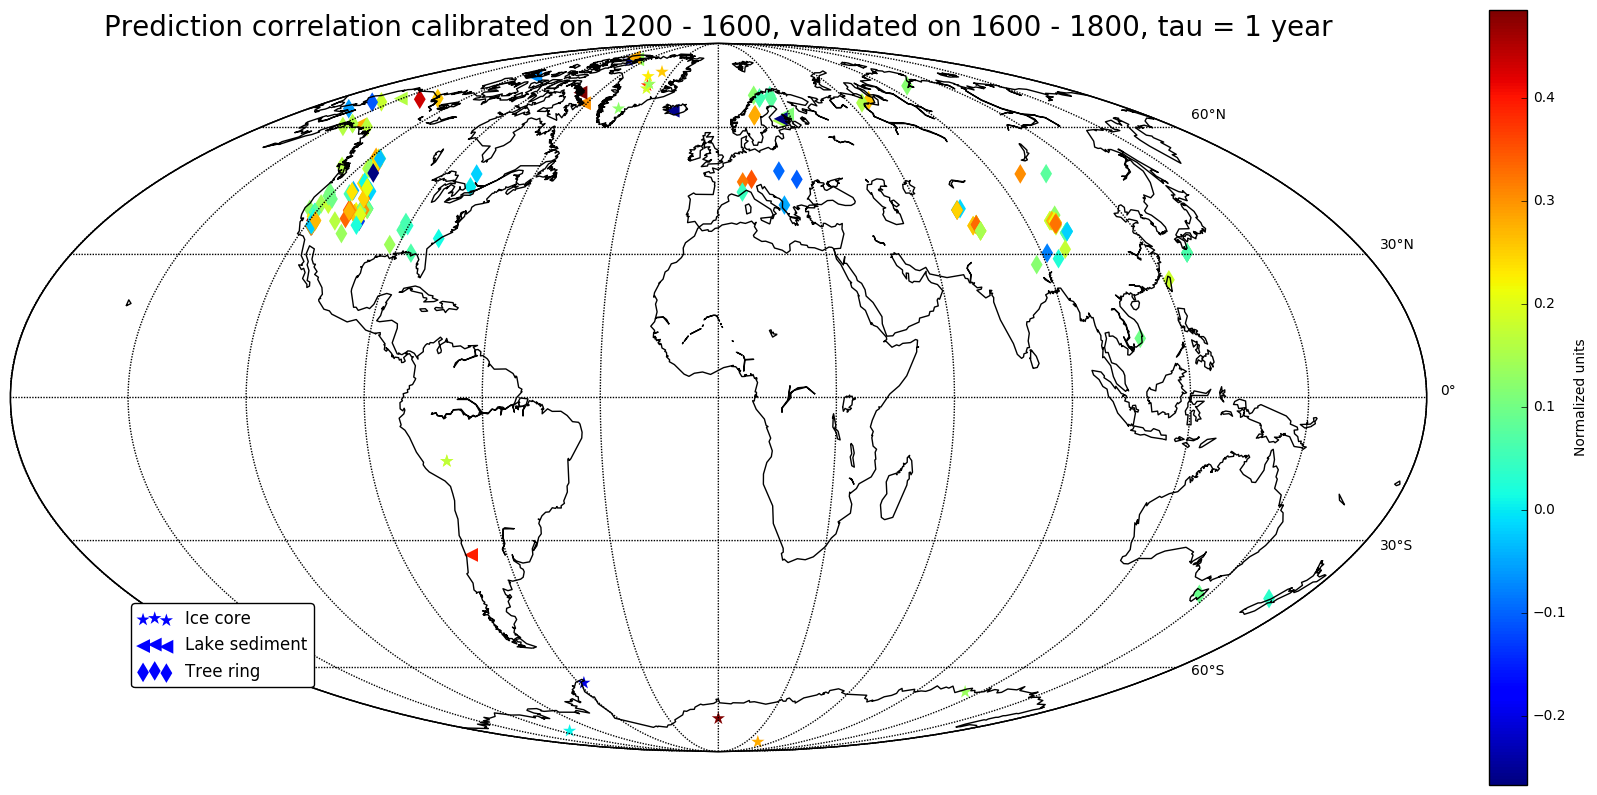

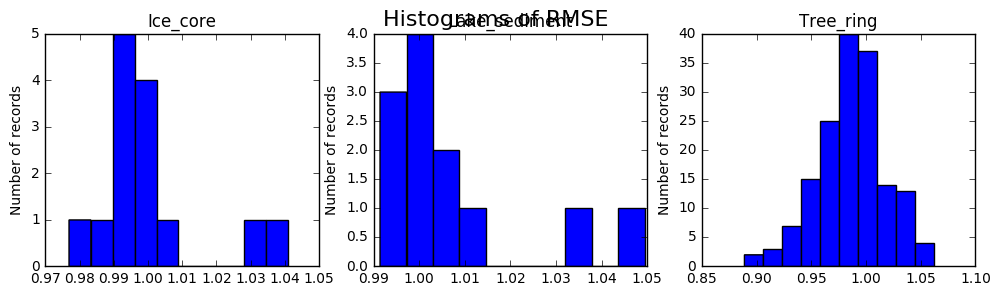

In [482]:
# Experiment 1
# 

tau = 1
calInt = [1200,1600]
valInt = [1600,1800]
#valInt = calInt

# Just don't use documentary for now - authors gave lat lon ranges rather than locations.
#data_types = {'c', 'i','l','m','s','t'}
data_types = {'c','h','ice','i','l','m','s','t'}
doEOF = True
doDetrend=True

corrdf,rmsedf,G,c0,ct,pmSkill = getSkill(data_types,proxy_data,proxy_meta,tau,calInt,valInt,doEOF,8,doDetrend)



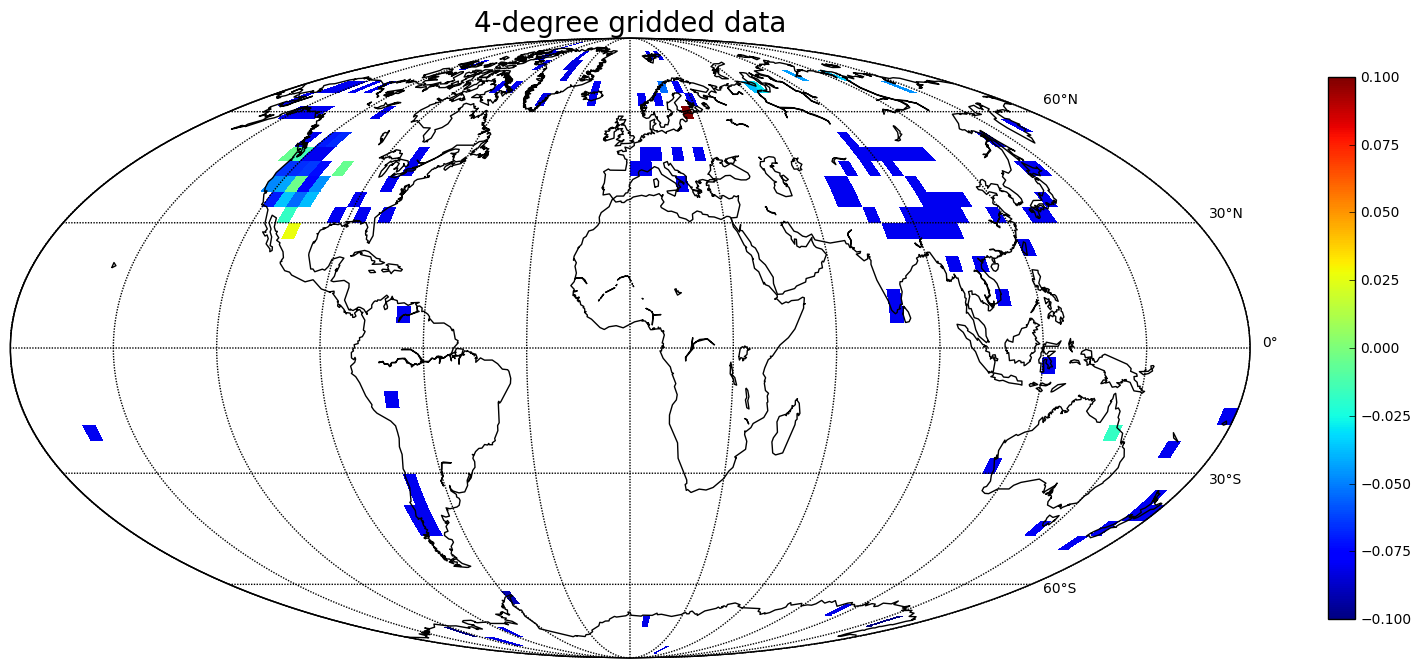

In [438]:
### Compute a spatially averaged field.

## NOTE: I NEED TO INCLUDE INFORMATION ABOUT THE TEMPERATURE SENSITIVTY SIGN IF THIS IS TO MAKE ANY SENSE! ##

from gridAvg import gridAvg
from getSkillGridded import getSkillGridded
RES = 4;
Gn, pmg, lat_g,lon_g = gridAvg(proxy_meta,proxy_data,RES,RES)
# Define a grid. RES is resolution in degrees.
# Mask and plot with basemap

#corrdf,rmsedf,G,c0,ct = getSkillGridded(Gn,1,[1100,1450],[1100,1450],True,50);

# Mask and plot one year as an example

plt.figure(figsize=(20,10))
m = Basemap(projection='moll',llcrnrlat=-87,urcrnrlat=81,lon_0=0,\
            llcrnrlon=0,urcrnrlon=360,resolution='c');
# draw parallels and meridians.
parallels = np.arange(-90.,90.,30.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[False,True,True,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,30.)
m.drawmeridians(meridians)
m.drawmapboundary(fill_color='white')

x,y = np.meshgrid(lon_g[:-1], lat_g[:-1])
#x,y = np.meshgrid(lon_c, lat_c)

Gnn = Gn[1800,:,:]
ax = plt.gca()
masked_array = np.ma.array(Gnn, mask=(np.isnan(Gnn)))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.0)

im1 = m.pcolormesh(x,y,Gnn,shading='flat',cmap=cmap,latlon=True);
im2 = m.pcolormesh(x,y,masked_array,shading='flat',cmap=cmap,latlon=True);
m.drawcoastlines();
cbar = plt.colorbar(im1,shrink=.7)
plt.title(str(RES) + '-degree gridded data',size=20)
#cbar.set_label('Number of records')




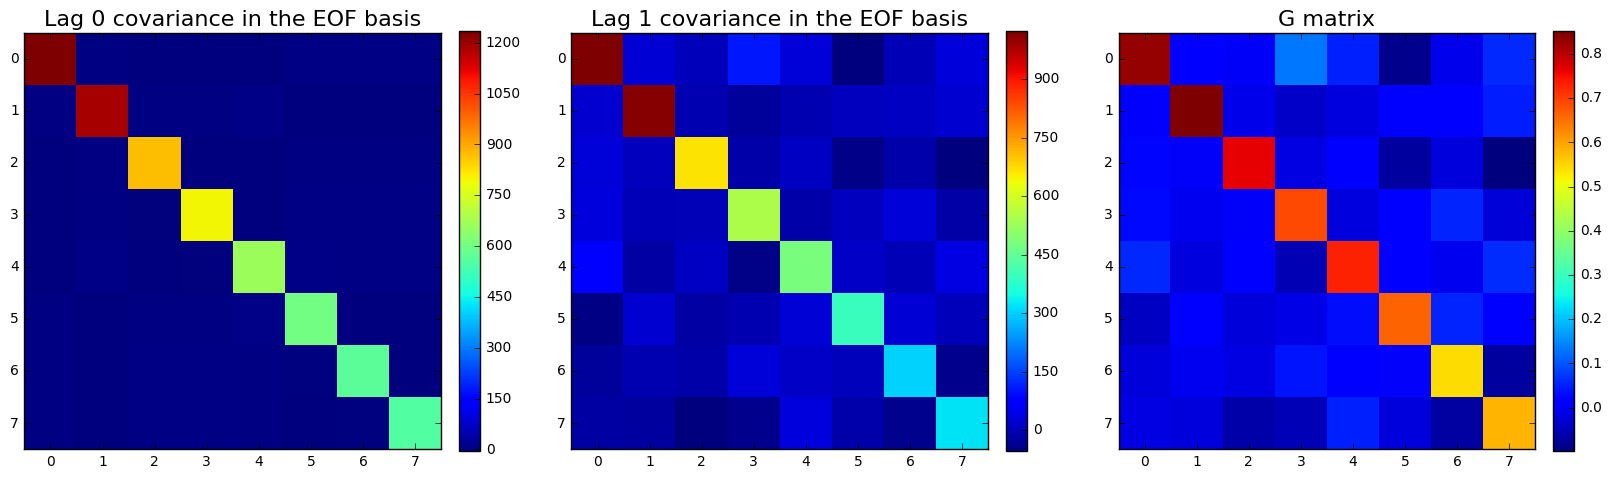

ValueError: total size of new array must be unchanged

In [443]:
# LIM of gridded data

#corrdf,rmsedf,G,c0,ct = getSkillGridded(Gn,1,[1100,1450],[1100,1450],True,50);

# Find data that aren't NaNs
mask=~np.isnan(np.nansum(Gn,0))

# Select those time series
g = Gn[:,mask];

# 

gdf = pandas.DataFrame(data=g,index=np.arange(0.,2012))

corrdf,rmsedf,G,c0,ct = getSkillGridded(gdf,1,[1100,1450],[1100,1450],True,8);

rmap = corrdf.values.reshape(192,288)